<a href="https://colab.research.google.com/github/susantok/susantok/blob/main/STK_Analisa_EPOCH_dan_THRESH_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3

import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import json

# library untuk gambar model yang dihasilkan
!pip install pydot
!apt-get install graphviz -y

import pydot
from keras.utils import plot_model
from IPython.display import Image

# Normalisasi Data
file_path = '/content/1420Jan.csv'
df = pd.read_csv(file_path)

# Biarkan pandas mencoba menentukan format tanggal dan waktu secara otomatis
df['TS'] = pd.to_datetime(df['TS'], errors='coerce')

df['NSM'] = df['TS'].dt.hour * 3600 + df['TS'].dt.minute * 60 + df['TS'].dt.second
df['WS'] = df['TS'].dt.dayofweek // 5
df['D'] = df['TS'].dt.dayofweek + 1

df['NSM'] = df['NSM'] / (24 * 3600)
df['TP'] = df['TP'] / 1200
df['T'] = (df['T'] + 20) / 70
df['H'] = (df['H'] - 20) / 60
df['Pb'] = df['Pb']
df['Pg'] = df['Pg']
df['S-AC'] = df['S-AC']

df['HR'] = (df['TS'].dt.month + df['TS'].dt.day + df['TS'].dt.year) / (12 + 31 + 9999)
df['WK'] = (df['TS'].dt.hour * 3600 + df['TS'].dt.minute * 60 + df['TS'].dt.second) / (24 * 3600)

df['TS'] = (df['TS'] - df['TS'].min()) / (df['TS'].max() - df['TS'].min())

# Hanya menyimpan kolom yang dibutuhkan
selected_columns = ['TP', 'S-TV', 'S-WPM', 'T', 'Pb', 'Pg', 'NSM', 'WS', 'HR', 'S-AC']
df_selected = df[selected_columns]

# Simpan Data yang Telah Dimodifikasi ke File CSV
csv_output_path = '/content/1420Jan-normalisasiOK.csv'
df_selected.to_csv(csv_output_path, index=False)

# Tampilkan beberapa baris data setelah dimodifikasi
print("Data setelah dimodifikasi:")
print(df_selected.head())

# Fungsi aktivasi sigmoid dan tanh
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

def tanh(x):
    return tf.math.tanh(x)

# Membaca file csv
df_train = pd.read_csv('/content/1420Jan-normalisasiOK.csv')

# Drop rows with NaN values
df_train.dropna(inplace=True)

# Mengambil input (TP, P, WS, WK, HR) dan output (S-AC)
X_train = df_train[['TP', 'S-TV', 'S-WPM', 'T', 'Pb', 'Pg', 'NSM', 'WS', 'HR']].values
y_train = df_train['S-AC'].values

# Menggunakan scaler untuk mengubah skala input dan output
# semua di transformasi ke nilai -1 sampai 1. untuk apa ya ? kalau 0 sampai 1 ?
scalerX_train = MinMaxScaler(feature_range=(-1, 1))
scalerX_train.fit(X_train)
X_train = scalerX_train.transform(X_train)

scalery_train = MinMaxScaler(feature_range=(-1, 1))
scalery_train.fit(y_train.reshape(-1, 1))
y_train = scalery_train.transform(y_train.reshape(-1, 1))

# Membagi data menjadi training, validasi, dan uji
# membagi data tes menjadi 20% dan training 80%
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# dari data training 80% sebelumnya dibagi lagi menjadi data validasi sebesar 25%, sisanya 75% jadi data tranining.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Membuat model LSTM
model = Sequential()
model.add(LSTM(units=25, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=25))
model.add(Dropout(0.1))
model.add(Dense(units=1))
#model.add(Dense(units=1, activation='sigmoid'))
# diketahui jumlah neuron LSTM adalah 25 neuron, semakin banyak jumlah datanya
# sebaiknya jumlah neuronya juga bertambah. namun hati-hati dengan overfitting dan komputasi yang lama
# dropout digunakan untuk mencegah overfitting, dimana nilainya adalah 0.1 atau 10% dari jumlah unit neuron



# Mengoptimasi model menggunakan Adam dan menjalankan early stopping
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# learning rate dikatikan dengan kompleksitas datanya, yaitu banyaknya fitur (kolom) serta variasi / rentang data yang tidak sama.

# Melatih model dengan parameter epoch dan batch_size
model.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Mengonversi parameter scaler ke format JSON
scalerX_train_params = {
    'scale_': scalerX_train.scale_.tolist(),
    'data_min_': scalerX_train.data_min_.tolist(),
    'data_max_': scalerX_train.data_max_.tolist(),
    'data_range_': scalerX_train.data_range_.tolist(),
    'min_': scalerX_train.min_.tolist(),
    # Hilangkan 'n_samples_seen_' dari dictionary
}

# Menyimpan parameter scaler ke dalam file JSON
scalerX_train_json_path = '/content/scalerX_train.json'
with open(scalerX_train_json_path, 'w') as json_file:
    json.dump(scalerX_train_params, json_file)


# Menampilkan pesan bahwa scalerX_train.json telah disimpan
print("Scaler parameters saved to:", scalerX_train_json_path)

# Menyimpan Model LSTM dalam format SavedModel
model.save('/content/lstm-ACmodel_savedmodel')
print("Model LSTM berhasil disimpan dalam format SavedModel.")

# Muat kembali model yang telah disimpan
loaded_model = tf.keras.models.load_model('/content/lstm-ACmodel_savedmodel')

# melihat ringakasan model
loaded_model.summary()

# Kompilasi model
loaded_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Membaca file csv untuk prediksi
df_pred = pd.read_csv('/content/1420Jan-normalisasiOK.csv')

# Mengambil input (TP, P, WS, WK, HR) untuk prediksi
X_pred = df_pred[['TP', 'S-TV', 'S-WPM', 'T', 'Pb', 'Pg', 'NSM', 'WS', 'HR']].values

# Menggunakan scaler yang sama untuk mengubah skala input
X_pred_scaled = scalerX_train.transform(X_pred)

# Menyesuaikan dimensi input untuk model LSTM
X_pred_scaled = X_pred_scaled.reshape((X_pred_scaled.shape[0], X_pred_scaled.shape[1], 1))

# Melakukan prediksi
y_pred_scaled = loaded_model.predict(X_pred_scaled)

# Menggunakan scaler untuk mengembalikan hasil prediksi ke skala asli
y_pred = scalery_train.inverse_transform(y_pred_scaled)

# Menambahkan hasil prediksi ke dataframe
df_pred['S-AC_Pred'] = y_pred

# Menetapkan nilai ambang
threshold = 0.5

# Mengganti nilai prediksi dengan 1 jika lebih besar dari ambang, dan 0 jika sebaliknya
df_pred['S-AC_Pred_Binary'] = (df_pred['S-AC_Pred'] > threshold).astype(int)

# Menyimpan hasil prediksi biner ke file CSV
csv_output_path_pred_binary = '/content/data_prediksi142001AC_binary.csv'
df_pred.to_csv(csv_output_path_pred_binary, index=False)

# Menampilkan beberapa baris hasil prediksi biner
print("Hasil prediksi biner:")
print(df_pred.head())



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Data setelah dimodifikasi:
         TP  S-TV  S-WPM         T  Pb  Pg       NSM  WS        HR  S-AC
0  0.281667     1      0  0.725714   1   1  0.000000   1  0.203047   1.0
1  0.281917     1      0  0.725714   1   1  0.000694   1  0.203047   1.0
2  0.280833     1      0  0.725714   1   1  0.001389   1  0.203047   1.0
3  0.281500     1      0  0.725714   1   1  0.002083   1  0.203047   1.0
4  0.281250     1      0  0.725714   1   1  0.002778   1  0.203047   1.0
Epoch 1/25
368/368 [==============================] - 11s 14ms/step - loss: 0.9513 - val_loss: 0.9063
Epoch 2/25
368/368 [==============================] - 4s 12ms/step - loss: 0.9107 - val_loss: 0.8632
Epoch 3/25
368/368 [==============================] - 5s 13ms/step - loss: 0.8529 - val_loss: 0.7765
Epoch 4/25
368/368 

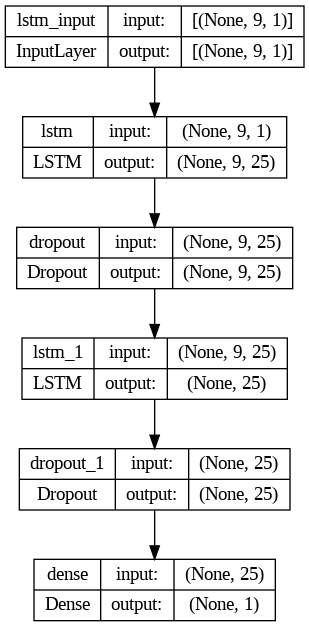

In [ ]:
# Plot model
plot_model(loaded_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Menampilkan gambar
Image('model_plot.png')

In [ ]:
# Menghapus baris yang mengandung nilai NaN dari dataframe
df_pred.dropna(inplace=True)

# Menampilkan jumlah nilai NaN setelah penghapusan
print("Jumlah nilai NaN di kolom 'S-AC':", df_pred['S-AC'].isna().sum())
print("Jumlah nilai NaN di kolom 'S-AC_Pred':", df_pred['S-AC_Pred'].isna().sum())

Jumlah nilai NaN di kolom 'S-AC': 0
Jumlah nilai NaN di kolom 'S-AC_Pred': 0


In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score
import numpy as np

# Menghitung Mean Squared Error (MSE)
mse = mean_squared_error(df_pred['S-AC'], df_pred['S-AC_Pred'])

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Menghitung akurasi
accuracy = accuracy_score(df_pred['S-AC'], df_pred['S-AC_Pred_Binary'])

# Menghitung akurasi dalam persen
#accuracy_percent = accuracy * 100

# Menghitung presisi
precision = precision_score(df_pred['S-AC'], df_pred['S-AC_Pred_Binary'])

# Menampilkan hasil
print("Performance Metrics:")
print("Accuracy:", accuracy)
#print("Accuracy (%):", accuracy_percent, "%")
print("Precision:", precision)
print("MSE:", mse)
print("RMSE:", rmse)



Performance Metrics:
Accuracy: 0.818144750254842
Precision: 0.7754842807240394
MSE: 0.13222385667382774
RMSE: 0.3636259845965738


# **Menguji Model dengan data uji dan menampilkan hasil prediksi**

In [ ]:
from keras.models import load_model
# memuar model dari direktori lstm-ACmodel_savedmodel
model_uji = load_model('/content/lstm-ACmodel_savedmodel')

# Kompilasi model
model_uji.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# menyiapkan data uji
# Normalisasi Data
file_path = '/content/1420JanUji.csv'
datauji = pd.read_csv(file_path)

# Biarkan pandas mencoba menentukan format tanggal dan waktu secara otomatis
datauji['TS'] = pd.to_datetime(datauji['TS'], errors='coerce')

datauji['NSM'] = datauji['TS'].dt.hour * 3600 + datauji['TS'].dt.minute * 60 + datauji['TS'].dt.second
datauji['WS'] = datauji['TS'].dt.dayofweek // 5
datauji['D'] = datauji['TS'].dt.dayofweek + 1

datauji['NSM'] = datauji['NSM'] / (24 * 3600)
datauji['TP'] = datauji['TP'] / 1200
datauji['T'] = (datauji['T'] + 20) / 70
datauji['H'] = (datauji['H'] - 20) / 60
datauji['Pb'] = datauji['Pb']
datauji['Pg'] = datauji['Pg']
datauji['S-AC'] = datauji['S-AC']

datauji['HR'] = (datauji['TS'].dt.month + datauji['TS'].dt.day + datauji['TS'].dt.year) / (12 + 31 + 9999)
datauji['WK'] = (datauji['TS'].dt.hour * 3600 + datauji['TS'].dt.minute * 60 + datauji['TS'].dt.second) / (24 * 3600)

datauji['TS'] = (datauji['TS'] - datauji['TS'].min()) / (datauji['TS'].max() - datauji['TS'].min())

# Hanya menyimpan kolom yang dibutuhkan
selected_columns = ['TP', 'S-TV', 'S-WPM', 'T', 'Pb', 'Pg', 'NSM', 'WS', 'HR', 'S-AC']
datauji_selected = datauji[selected_columns]

# Simpan Data yang Telah Dimodifikasi ke File CSV
csv_output_path = '/content/1420JanUji-normalisasiOK.csv'
datauji_selected.to_csv(csv_output_path, index=False)

#=========================
# Membaca file csv untuk prediksi
datauji_pred = pd.read_csv('/content/1420JanUji-normalisasiOK.csv')

# Mengambil input untuk prediksi yang sesuai hasil korelasi |0.02|
Xdatauji_pred = datauji_pred[['TP', 'S-TV', 'S-WPM', 'T', 'Pb', 'Pg', 'NSM', 'WS', 'HR']].values

# Menggunakan scaler yang sama untuk mengubah skala input
Xdatauji_pred_scaled = scalerX_train.transform(Xdatauji_pred)

# Menyesuaikan dimensi input untuk model LSTM
Xdatauji_pred_scaled = Xdatauji_pred_scaled.reshape((Xdatauji_pred_scaled.shape[0], Xdatauji_pred_scaled.shape[1], 1))

# Melakukan prediksi
ydatauji_pred_scaled = model_uji.predict(Xdatauji_pred_scaled)

# Menggunakan scaler untuk mengembalikan hasil prediksi ke skala asli
ydatauji_pred = scalery_train.inverse_transform(ydatauji_pred_scaled)

# Menambahkan hasil prediksi ke dataframe
datauji_pred['S-AC_Pred'] = ydatauji_pred

# Menetapkan nilai ambang
threshold = 0.5

# Mengganti nilai prediksi dengan 1 jika lebih besar dari ambang, dan 0 jika sebaliknya
datauji_pred['S-AC_Pred_Binary'] = (datauji_pred['S-AC_Pred'] > threshold).astype(int)

# Menampilkan beberapa baris hasil prediksi biner
print("Hasil prediksi biner:")
print(datauji_pred.head())

1/1 [==============================] - 2s 2s/step
Hasil prediksi biner:
        TP  S-TV  S-WPM         T  Pb  Pg       NSM  WS        HR  S-AC  \
0  0.25825     1      0  0.730714   1   1  0.615278   0  0.203744     0   

   S-AC_Pred  S-AC_Pred_Binary  
0   0.191262                 0  
